In [1]:

import numpy as np 
import tensorflow as tf 
import random 
import os 
import string 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
seed=42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
train_data=pd.read_csv("sign_mnist_train.csv")
test_data=pd.read_csv("sign_mnist_test.csv")
print("Shape of train_data: ",train_data.shape,"Shape of test_data: ",test_data.shape)

Shape of train_data:  (27455, 785) Shape of test_data:  (7172, 785)


In [5]:
strlabels=list(string.ascii_uppercase) 
strlabels.remove("J") 
print(strlabels) 

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [6]:
train_labels=train_data["label"]
train_images=train_data.drop("label",axis=1).values 
test_labels=test_data["label"]
test_images=test_data.drop("label",axis=1).values 
                                               
train_images=train_images/255.0 
test_images=test_images/255.0

train_images=train_images.reshape(-1,28,28,1) 
test_images=test_images.reshape(-1,28,28,1)
print(train_images.shape) 

(27455, 28, 28, 1)


[Text(0, 0.5, 'Test Images'), Text(0.5, 0, 'Test Labels')]

<Figure size 640x480 with 0 Axes>

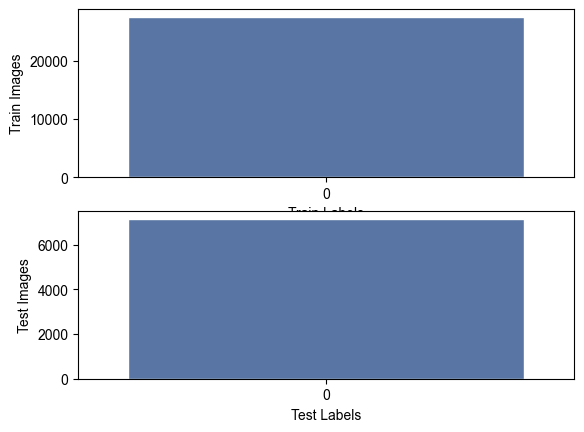

In [7]:
plt.figure() 
plt.tight_layout() 
fig,ax=plt.subplots(2,1) 
sns.set(rc={'figure.figsize':(15,5)}) 
sns.countplot(train_labels,ax=ax[0])
ax[0].set(ylabel="Train Images", xlabel = "Train Labels") 
sns.countplot(test_labels,ax=ax[1])
ax[1].set(ylabel="Test Images", xlabel = "Test Labels")

<Figure size 1500x500 with 0 Axes>

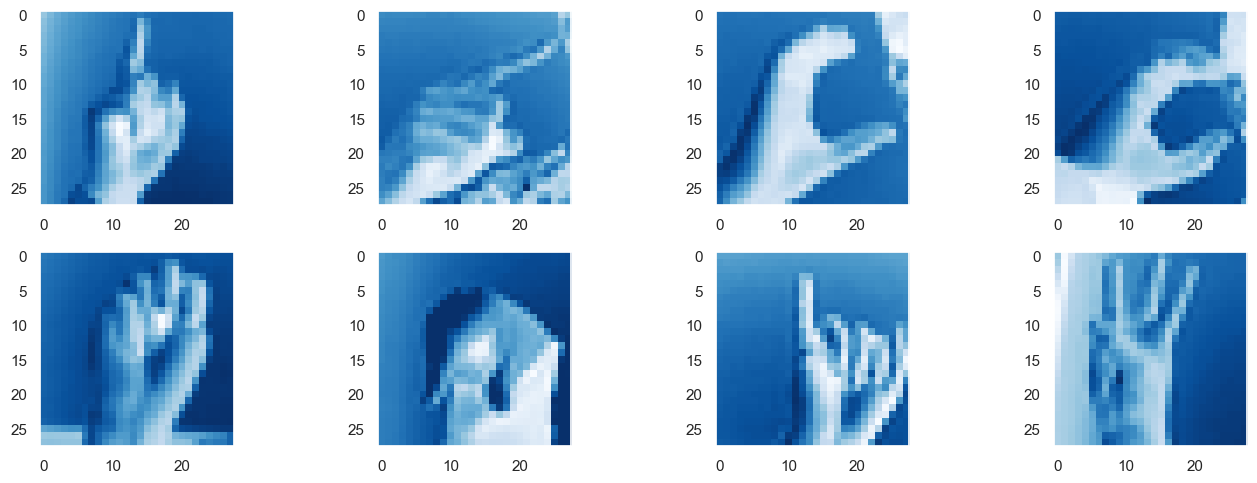

In [13]:
plt.figure()
f, graph = plt.subplots(2,4) 
f.set_size_inches(14, 5) 
z=0
for i in range(2): 
    for k in range(4): 
        graph[i][k].imshow(train_images[z].reshape(28,28),cmap="Blues") 
        graph[i][k].grid(False) 
        z+=1
plt.tight_layout() 
plt.show()

In [14]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10, 
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  
generator.fit(train_images)

In [15]:
acc_treshold = 1.0 
class myCallback(tf.keras.callbacks.Callback):
    epc=0
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') >= acc_treshold-0.0100 and logs.get('val_acc') >= acc_treshold):
            print("\nReached %2.2f%% accuracy !" %(logs.get('val_acc')*100)) 
            self.model.stop_training = True
            self.epc=epoch+1
callbacks = myCallback()

In [16]:
model=tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu",input_shape=(28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2),strides=2),
    
    tf.keras.layers.Dropout(0.2), 
    
    tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2),strides=2),
    
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25,activation="softmax")
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),loss="sparse_categorical_crossentropy",metrics=["acc"])
model.summary() 
epochs=80
history=model.fit(generator.flow(train_images,train_labels,batch_size=128),epochs=epochs,callbacks=[callbacks],validation_data=(test_images,test_labels),verbose=1)
test_loss,test_acc=model.evaluate(test_images,test_labels)
print("test acc:",test_acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       1

In [17]:
prediction=model.predict(test_images) 

225/225 [==============================] - 4s 15ms/step


<Figure size 1500x500 with 0 Axes>

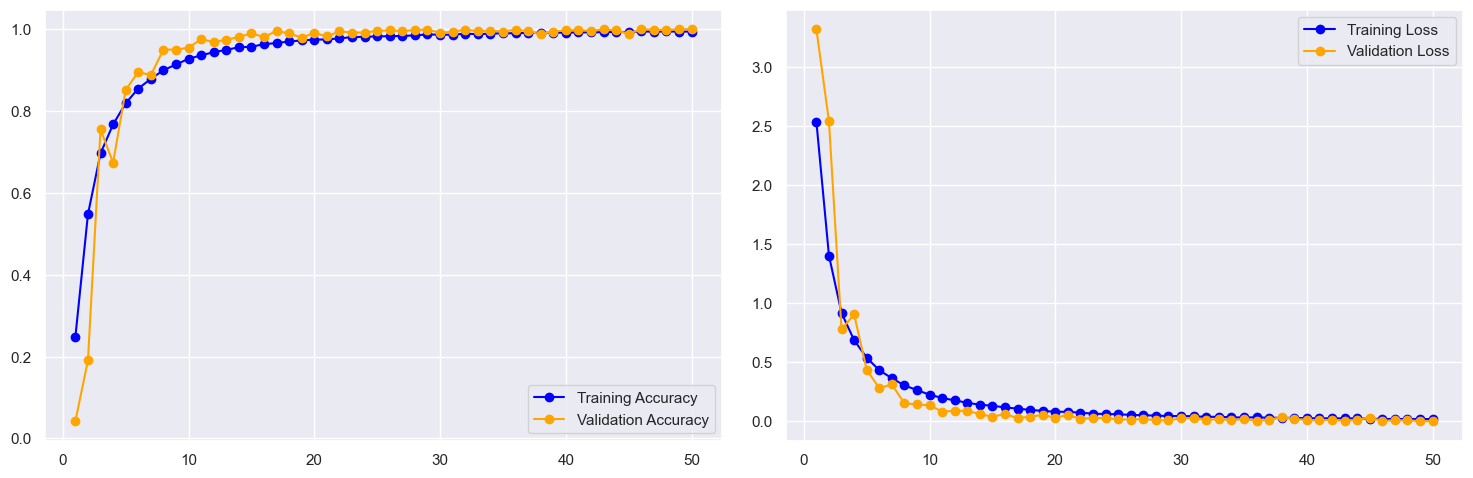

In [18]:
epoch_range=range(1,callbacks.epc+1 if callbacks.epc != 0 else epochs) 
plt.figure() 
f, ax = plt.subplots(1,2) 
fig.set_size_inches(30, 5) 
plt.tight_layout() 
ax[0].plot(epoch_range,history.history["acc"],color="blue",marker="o")
ax[0].plot(epoch_range,history.history["val_acc"],color="orange",marker="o")
ax[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
ax[1].plot(epoch_range,np.array(history.history["loss"]),color="blue",marker="o")
ax[1].plot(epoch_range,np.array(history.history["val_loss"]),color="orange",marker="o")
ax[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [19]:
predictions=[]
test_labels_string=[]
for i in range(0,test_labels.size):
    predictions.append(strlabels[np.argmax(prediction[i])]) 
    test_labels_string.append(strlabels[test_labels[i]])
# Converting predictions to letters.

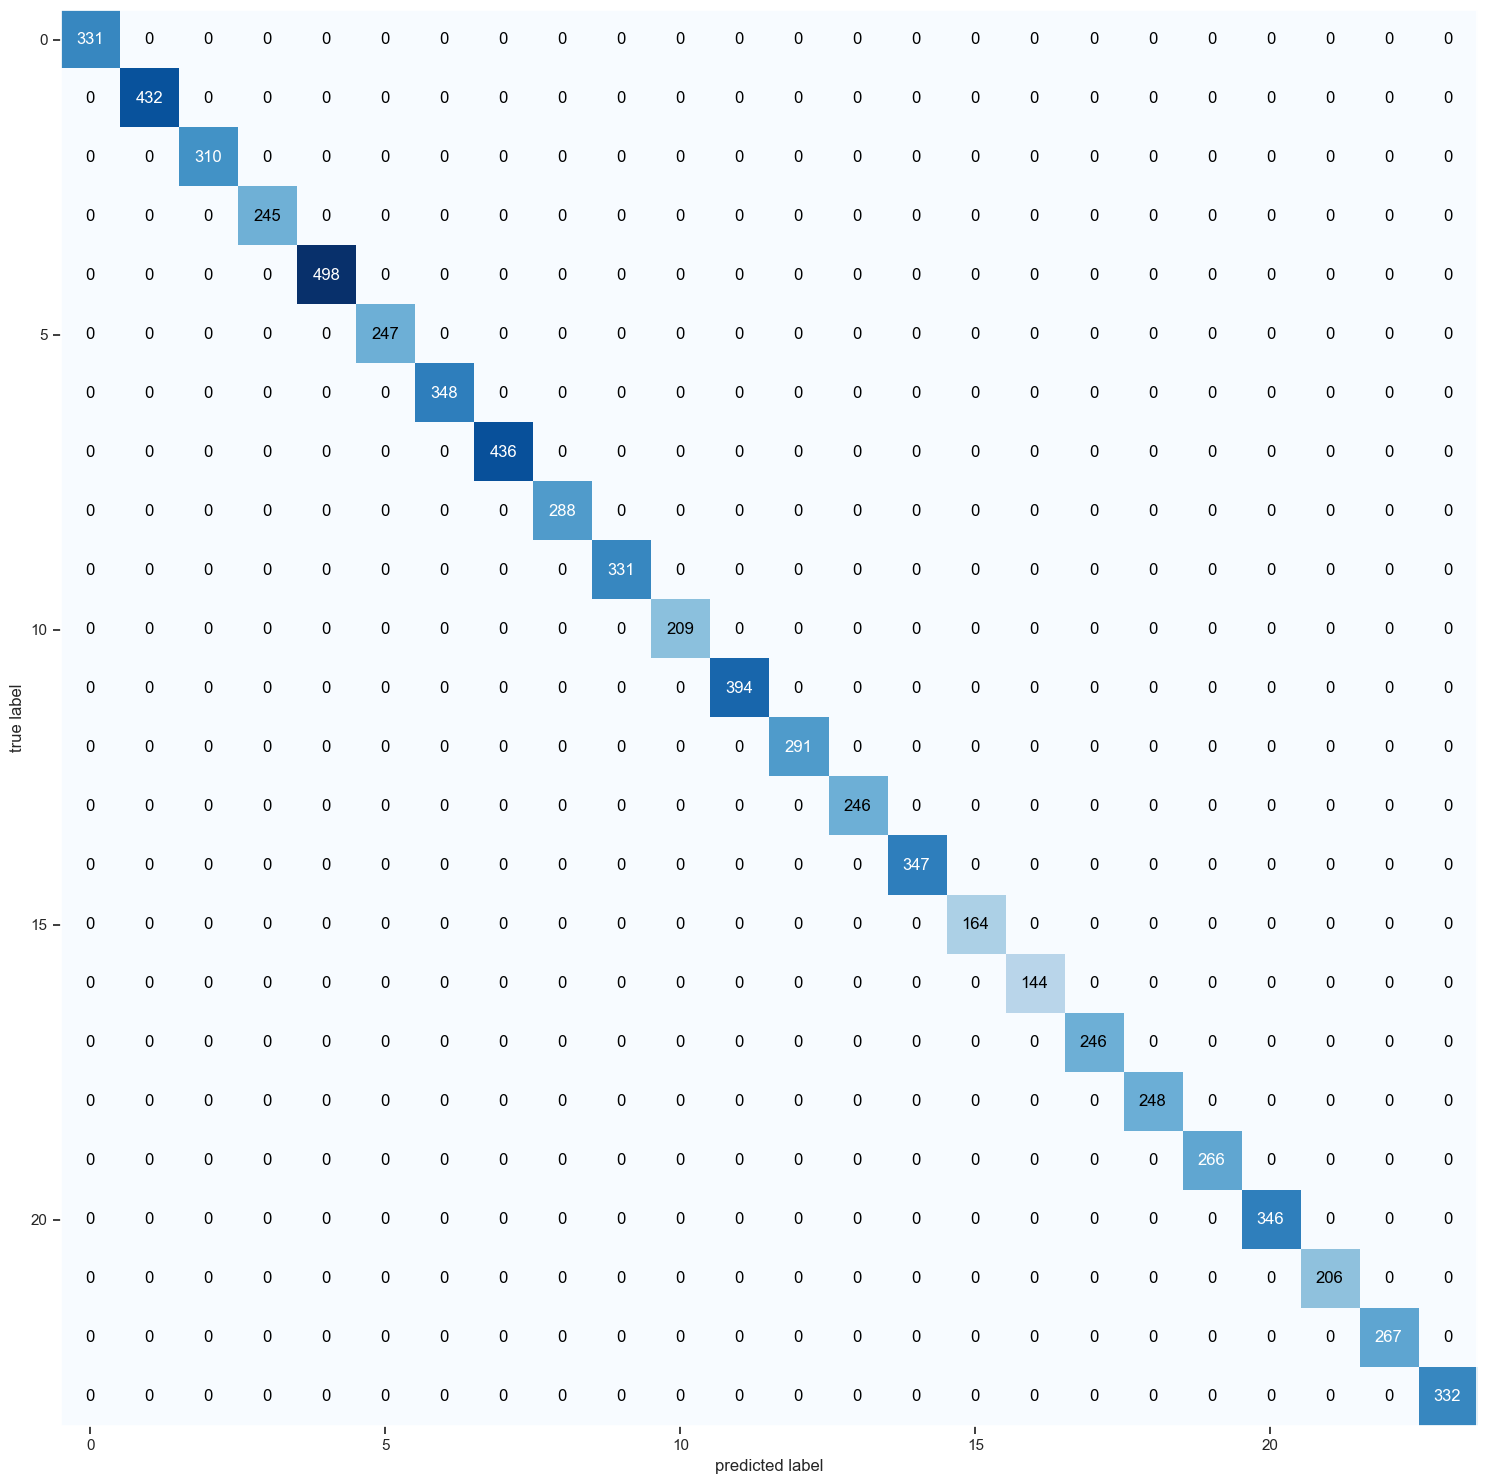

In [21]:
from sklearn.metrics import confusion_matrix 
from mlxtend.plotting import plot_confusion_matrix 
cf=confusion_matrix(predictions,test_labels_string)
fig, ax = plot_confusion_matrix(conf_mat=cf)
fig.set_size_inches(15, 15) 
plt.tight_layout() 

Predicted letter is: D 
True Answer: D


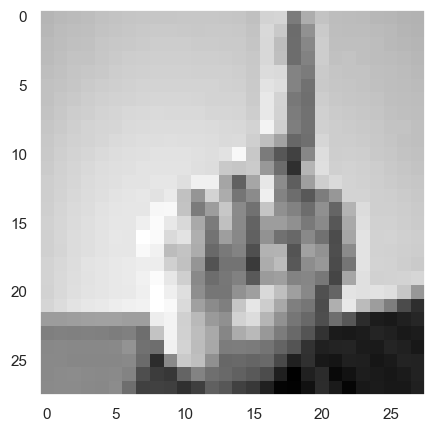

In [24]:
n=4
plt.imshow(test_images[n].reshape(28,28),cmap="gray") 
plt.grid(False) 
print("Predicted letter is:",predictions[n],"\nTrue Answer:",test_labels_string[n])  